# **Lab: Adaptive mesh refinement**
**Gustav Grevsten**

# **Abstract**

In this report, the FEniCS Python library was used in order to implement a mixed finite element method to solve the the Stokes equations in 2D. A mesh with a cylinder was created and this cylinder was then moved around the grid to observe the difference in the adjoint solutions. Furthermore, the grid was adaptively refined in response to the measured error of the solution, with a recursive refinement method implemented at the end.

# **About the code and report**

Most of the code as well as the introduction were provided courtesy of Prof. Johan Hoffman (jhoffman@kth.se) as a part of the course DD2365, Advanced Computation in Fluid Mechanics, at KTH Royal Institute of Technology, Stockholm, Sweden.

# **Set up environment**

In [1]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)

--2023-04-19 18:23:35--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4156 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2023-04-19 18:23:35 (49.6 MB/s) - ‘/tmp/fenics-install.sh’ saved [4156/4156]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/bef019f/releases/pybind11-install.s

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with boundary conditions for $\partial \Omega = \Gamma_D \cup \Gamma_N \cup \Gamma_F$

$
u=g_D,\quad x\in \Gamma_D
$

$
u=0,\quad x\in \Gamma_F
$

$
-\nabla u\cdot n + pn = 0,\quad x\in \Gamma_N
$

Here $\Gamma_D$ is the part of the boundary where we prescribe Dirichlet boundary conditions, $\Gamma_N$ a part of the boundary where we apply a homogeneous Neumann boundary condition, and $\Gamma_F$ the part of the boundary over which we want to compute the force. 

The weak (variational) form of the equations is: find a solution $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) = (f,v)$

for all test functions $(v,q) \in \hat V \times Q$, where $\hat V$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(U,P)\in V_h\times Q_h$ such that 

$- (P,\nabla \cdot v) + (\nabla U,\nabla v) + (\nabla \cdot U, q) = (f,v)$

for all test functions $(v,q) \in \hat V_h \times Q_h$, where $\hat V_h$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$. Here $V_h\subset V, Q_h\subset Q, \hat V_h\subset \hat V$ are finite dimensional subspaces defined over the computational mesh by finite element basis functions. 

To implement the velocity Dirichlet boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, where $C>0$ is a constant and $h$ is the local mesh size. At the outflow a "do nothing" zero stress boundary condition is used, meaning that the boundary condition is enforced weakly by setting the boundary integral to zero. 

We consider the linear functional $F:V\times Q\rightarrow {\mathbb R}$, 

$F(v,q) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} + \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}$

corresponding to weighted mean values of $v$ and $q$, and the force on the surface $\Gamma_F\subset \partial \Omega$, 
which generates the adjoint Stokes equations

$-\nabla \theta -\Delta \varphi = \psi_1,\quad -\nabla \cdot \varphi=\psi_2,$

together with boundary conditions that reflect the primal equations and the chosen functional. 

$
\varphi=0,\quad x\in \Gamma_D
$

$
\varphi=\psi_3,\quad x\in \Gamma_F
$

$
- \nabla \varphi \cdot n - \theta n=0, \quad x\in \Gamma_N
$

The weak form of the adjoint Stokes equations take the form: find $(\varphi,\theta)\in \hat V\times Q$ such that 

$- (q,\nabla \cdot \varphi) + (\nabla v,\nabla \varphi) + (\nabla \cdot v, \theta) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} - \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}= F(v,q)$

for all test functions $(v,q) \in V\times Q$. 

Since the Stokes equations are linear we can express the error in the linear functional with respect to an approximation $(u,p)\approx (U,P)$ as

$F(u,p) - F(U,P) = (f,\varphi) + (P,\nabla \cdot \varphi) - (\nabla U,\nabla \varphi) - (\nabla \cdot U, \theta) = r(U,P;\varphi,\theta) = \sum_K {\mathcal E}_K$

where we used that $F(u,p)=(f,\varphi)$ since $\varphi \in \hat V$, 
with the error indicator 

${\mathcal E}_K = r(U,P;\varphi,\theta)\vert _K$, 

which is the local residual on weak form with the solution to the adjoint equation as test function. The error indicator ${\mathcal E}_K$ can be used as an indicator for where to refine the mesh to reduce the global error as efficiently as possible. 

Note however that since $(U,P)\in V\times Q$ is the solution of a Galerkin finite element method, if we use the approximation $(\varphi,\theta) \approx (\varphi_h,\theta_h) \in \hat V_h\times Q_h$, the error indicators sum to zero. Hence, this sum cannot be used as a stopping criterion for an adaptive algorithm. Instead we may use error estimates of the type 

$
{\mathcal E}_K \leq C h_K  (\Vert \nabla \varphi_h \Vert_K + \Vert \nabla \theta_h\Vert_K) \Vert R(U,P)\Vert_K
$

where $R(U,P)=(R_1(U,P),R_2(U))$ is the residual of the equations in strong form, with 

$
R_1(U,P) = f + \Delta U - \nabla P
$

$
R_2(U) = \nabla \cdot U
$

# **Method**

For this lab, a mesh with a uniform mesh size of $h = \frac{1}{32}$ was used with the dimensions $4 \times 4$. This mesh contained a cylinder with a radius of $r=0.2$. This cylinder was then moved around the grid for the various tests.

**Define domain and mesh**

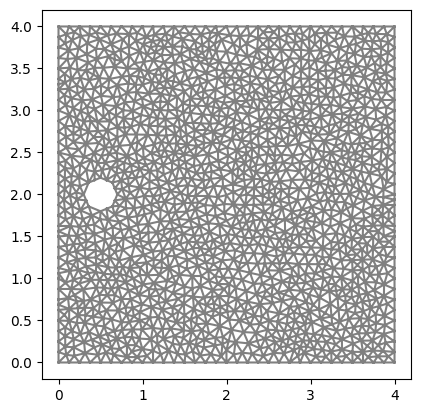

In [12]:
def rect_mesh(holes, resolution = 32, base = 4, height = 4, levels = 0):

  geometry = Rectangle(Point(0.0,0.0), Point(base,height))

  # Each hole is a list in the format [centre coordinate = [x, y], radius]
  for hole in holes:
    geometry -= Circle(Point(hole[0][0],hole[0][1]), hole[1])

  mesh = generate_mesh(geometry, resolution)

  # Local mesh refinement (specified by a cell marker)
  for hole in holes:
    for i in range(0,levels):
      cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
      for cell in cells(mesh):
        cell_marker[cell] = False
        p = cell.midpoint()
        if p.distance(Point(hole[0][0],hole[0][1])) < 1.1:
          cell_marker[cell] = True
      mesh = refine(mesh, cell_marker)

  return mesh

plt.figure()
plot(rect_mesh([[[0.5, 2], 0.2]]))
plt.show()

**Define finite element approximation spaces and boundary conditions**

In [3]:
def function_space(mesh, H = 4, L = 4):
  # Generate mixed finite element spaces (for primal velocity and pressure)
  VE = VectorElement("CG", mesh.ufl_cell(), 2)
  QE = FiniteElement("CG", mesh.ufl_cell(), 1)
  WE = VE * QE

  W = FunctionSpace(mesh, WE)
  V = FunctionSpace(mesh, VE)
  Q = FunctionSpace(mesh, QE)

  # Define trial and test functions
  w = Function(W)
  (u, p) = (as_vector((w[0],w[1])), w[2])
  (v, q) = TestFunctions(W) 

  # Generate mixed finite element spaces (for adjoint velocity and pressure)
  VEa = VectorElement("CG", mesh.ufl_cell(), 3)
  QEa = FiniteElement("CG", mesh.ufl_cell(), 2)
  WEa = VEa * QEa

  Wa = FunctionSpace(mesh, WEa)
  Va = FunctionSpace(mesh, VEa)
  Qa = FunctionSpace(mesh, QEa)

  # Define adjoint trial and test functions
  wa = Function(Wa)
  (phi, theta) = (as_vector((wa[0],wa[1])), wa[2])
  (va, qa) = TestFunctions(Wa)

  # Examples of inflow and outflow conditions
  XMIN = 0.0; XMAX = L
  YMIN = 0.0; YMAX = H
  uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
  #pout = 0.0

  # Inflow boundary (ib), outflow boundary (ob), body boundary (bb) and wall boundary (wb)
  ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
  ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) 
  wb = Expression("near(x[1],YMIN) || near(x[1],YMAX) ? 1. : 0.", YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())
  bb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())

  return VE, QE, WE, W, V, Q, w, u, p, v, q, VEa, QEa, WEa, Wa, Va, Qa, wa, phi, theta, va, qa, uin, ib, ob, wb, bb

# **Results**

**Define, solve and plot the variational problems**

In [4]:
def solve_var(mesh, psi = (("0.0","0.0"), "0.0", ("1.0", "0.0")), recursive_refinement = False):

  if recursive_refinement:
    thresh = 10**-5
  else:
    thresh = 10**10

  tot_err = 10**11 #Initialize at a value great enough to start the loop

  while abs(tot_err) > thresh:
    VE, QE, WE, W, V, Q, w, u, p, v, q, VEa, QEa, WEa, Wa, Va, Qa, wa, phi, theta, va, qa, uin, ib, ob, wb, bb = function_space(mesh)
    # Set boundary penalty parameter gamma 
    h = CellDiameter(mesh)
    C = 1.0e3
    gamma = C/h

    # Set force in primal problem
    f = Expression(("0.0","0.0"), element = V.ufl_element())

    # Set data that describe functional that defines the adjoint problem
    #psi1 = Expression(("exp(-10.0*(pow(x[0]-2.0,2) + pow(x[1]-1.5,2)))","0.0"), element = V.ufl_element())
    #psi2 = Expression("exp(-10.0(pow(x[0]-2.0,2) + pow(x[1]-1.0,2)))", element = Q.ufl_element())
    psi1 = Expression(psi[0], element = V.ufl_element())
    psi2 = Expression(psi[1], element = Q.ufl_element())
    phi3 = Expression(psi[2], element = V.ufl_element())

    # Define primal variational problem on residual form: r(u,p;v,q) = 0
    res = ( -p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx - inner(f, v)*dx + 
            gamma*(ib*inner(u - uin, v) + wb*inner(u, v) + bb*inner(u, v))*ds )

    # Solve primal algebraic system 
    solve(res == 0, w) 

    # Define adjoint variational problem on residual form: r(u,p;v,q) = 0
    res_a = ( -qa*div(phi)*dx + inner(grad(va), grad(phi))*dx + div(va)*theta*dx + 
              gamma*(ib*inner(phi, va) + wb*inner(phi, va) + bb*inner(phi - phi3, va))*ds 
            - inner(va, psi1)*dx - qa*psi2*dx )

    # Solve adjoint algebraic system 
    solve(res_a == 0, wa)

    # Initiate functions to save and visualize the solutions
    u_fcn = project(u, V)
    p_fcn = project(p, Q)
    phi_fcn = project(phi, V)
    theta_fcn = project(theta, Q)

    # Plot solution
    plt.figure()
    plot(u_fcn, title="Velocity")
    plt.figure()
    plot(p_fcn, title="Pressure")

    plt.figure()
    plot(phi_fcn, title="Adjoint velocity")

    plt.figure()
    plot(theta_fcn, title="Adjoint pressure")
            
    plt.show()

    # Define function space over the elements of the mesh
    WDG = FunctionSpace(W.mesh(), "DG", 0)
    elm = TestFunction(WDG)
    err_ind = Function(WDG)

    # Compute local error indicators over the cells of the mesh 
    local_error = ( elm*inner(f, phi)*dx + elm*p*div(phi)*dx - elm*inner(grad(u), grad(phi))*dx - elm*div(u)*theta*dx ) 
    err_ind.vector()[:] = assemble(local_error)
    err_ind_abs = np.abs(err_ind.vector())
    err_ind_mean = err_ind_abs.sum()/err_ind.vector().size()

    # Local mesh refinement (specified by a cell marker)
    no_levels = 1
    for i in range(0,no_levels):
      cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
      for c in cells(mesh):
        cell_marker[c] = False
        local_error_cell = err_ind_abs[c.index()] 
        if local_error_cell > err_ind_mean:
            cell_marker[c] = True
      mesh = refine(mesh, cell_marker)

    plt.figure()
    plot(mesh)
    plt.show()

    err_ind_sum = ( inner(f, phi)*dx + p*div(phi)*dx - inner(grad(u), grad(phi))*dx - div(u)*theta*dx - 
                  gamma*(ib*inner(u - uin, phi) + wb*inner(u, phi) + bb*inner(u, phi))*ds )

    tot_err = assemble(err_ind_sum)
    s = 'Total error = ' + repr(tot_err) 
    print(s)

Firstly, we investigate how the drag forces are affected by the position of the cylinder, with the functional: $\hspace{3mm} \psi_1 = (0,0), \hspace{3mm} \psi_2 = 0, \hspace{3mm} \psi_3 = (1,0)$.

We start with the cylinder centered at the coordinates $(0.5, 2)$:

DEBUG:UFL:Blocks of each mode: 
  7	full
DEBUG:UFL:Blocks of each mode: 
  2	full
DEBUG:UFL:Blocks of each mode: 

DEBUG:UFL:Blocks of each mode: 
  2	full
DEBUG:UFL:Blocks of each mode: 
  7	full
DEBUG:UFL:Blocks of each mode: 
  2	full
DEBUG:UFL:Blocks of each mode: 

DEBUG:UFL:Blocks of each mode: 
  2	full
DEBUG:UFL:Blocks of each mode: 

DEBUG:UFL:Blocks of each mode: 
  2	full
DEBUG:UFL:Blocks of each mode: 

DEBUG:UFL:Blocks of each mode: 
  1	full
DEBUG:UFL:Blocks of each mode: 
  2	full
DEBUG:UFL:Blocks of each mode: 
  1	full


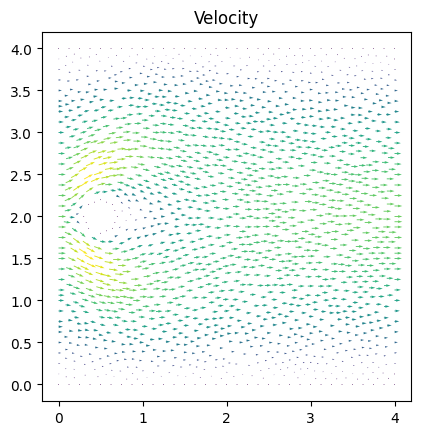

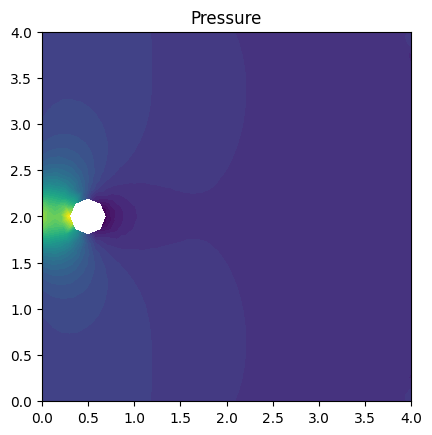

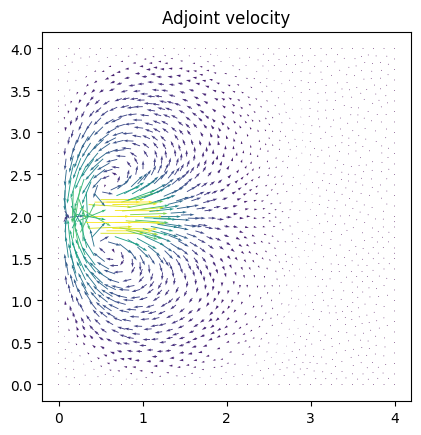

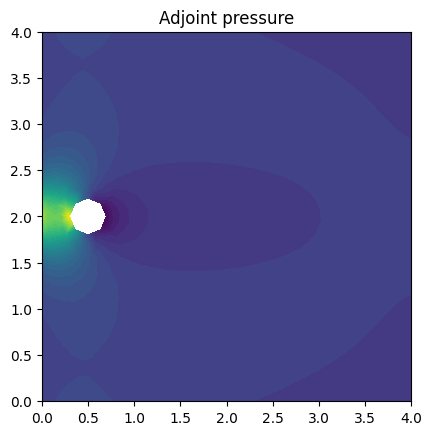

DEBUG:UFL:Blocks of each mode: 
  1	full


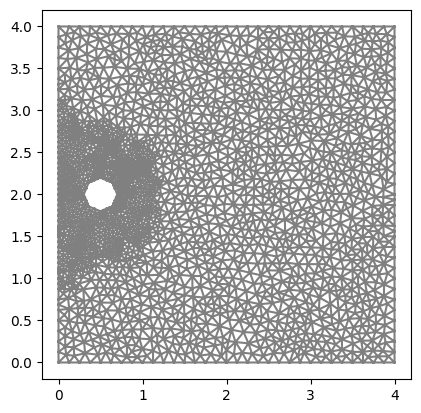

DEBUG:UFL:Blocks of each mode: 
  1	full
DEBUG:UFL:Blocks of each mode: 
  1	full


Total error = 0.050622244947699326


In [5]:
x, y = 0.5, 2 #circle coordinates
r = 0.2 #circle radius
mesh = rect_mesh([[[x, y], r]])
solve_var(mesh)

Next, the cylinder is centered at the coordinates $(2, 3.5)$:

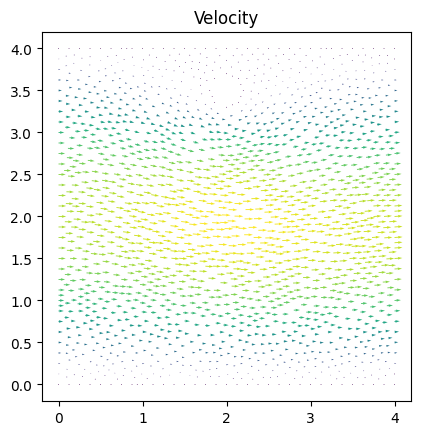

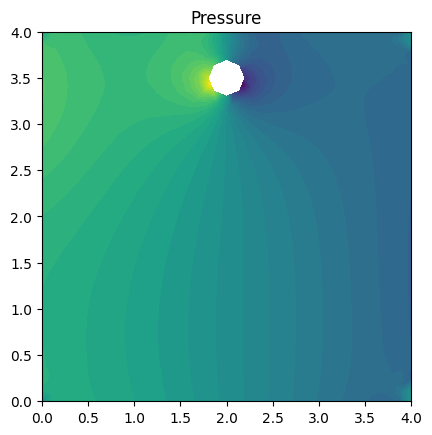

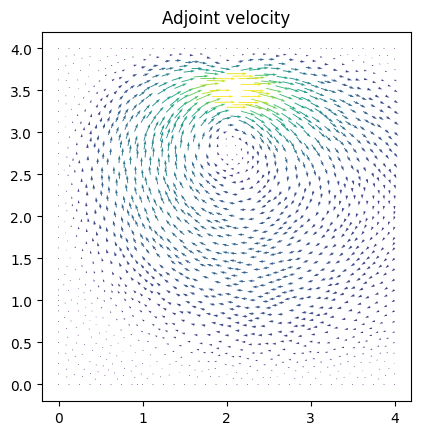

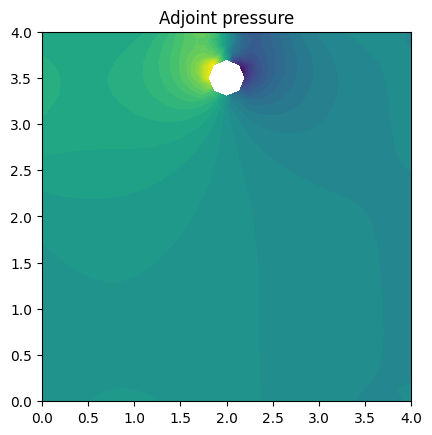

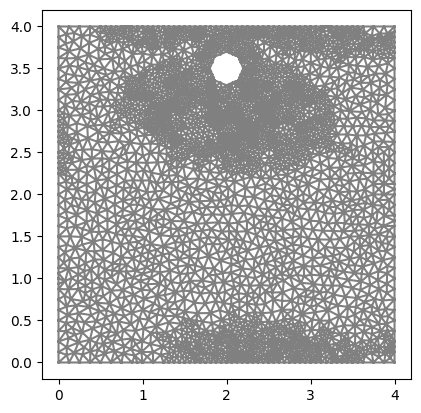

Total error = 0.0032052048054208642


In [ ]:
x, y = 2, 3.5 #circle coordinates
r = 0.2 #circle radius
mesh = rect_mesh([[[x, y], r]])
solve_var(mesh)

Next, the cylinder is centered at the coordinates $(2, 2)$:

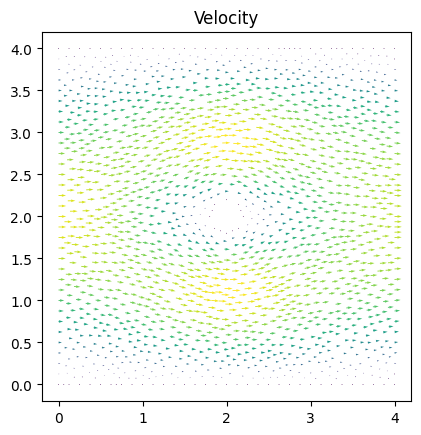

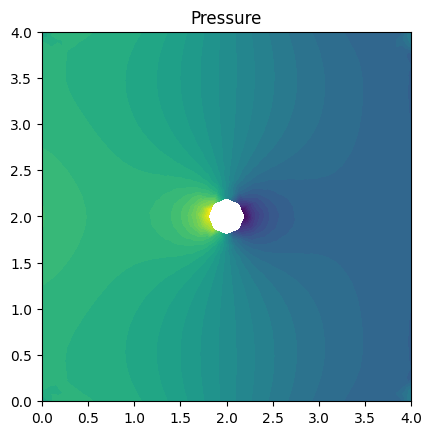

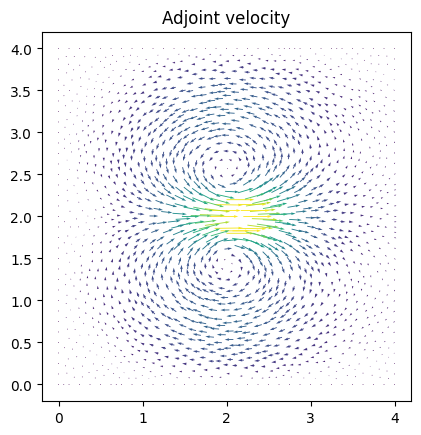

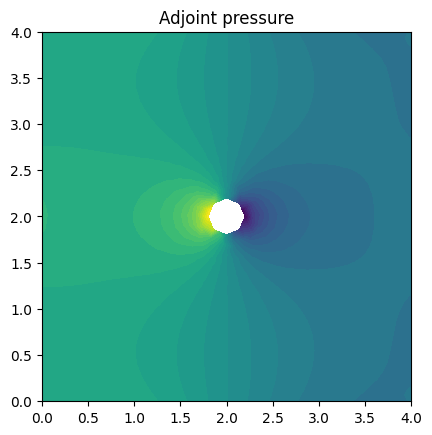

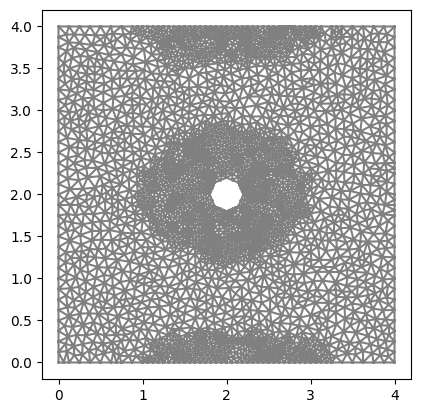

Total error = 0.006856127063298895


In [ ]:
x, y = 2, 2 #circle coordinates
r = 0.2 #circle radius
mesh = rect_mesh([[[x, y], r]])
solve_var(mesh)

Next, the cylinder is centered at the coordinates $(0.5, 0.5)$:

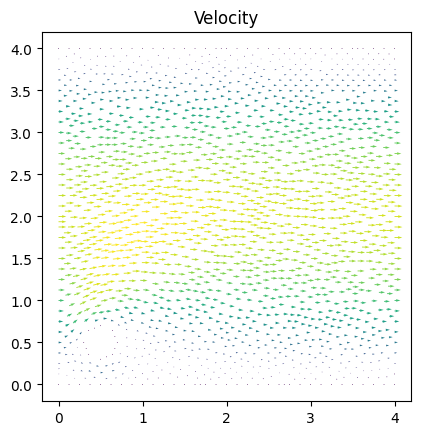

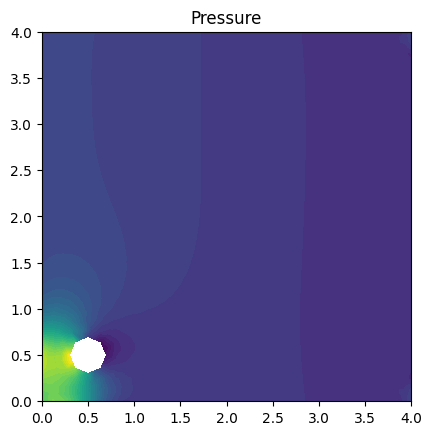

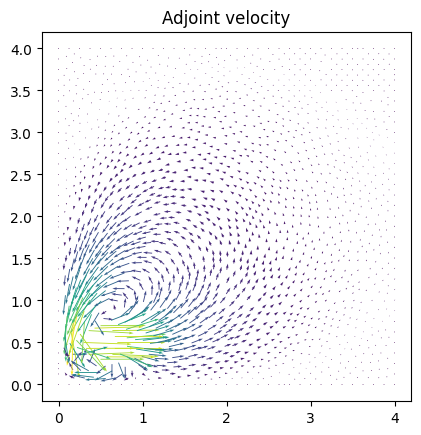

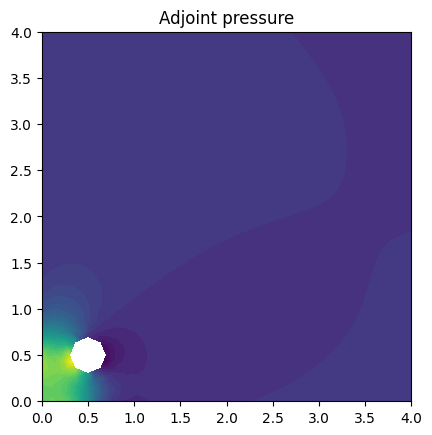

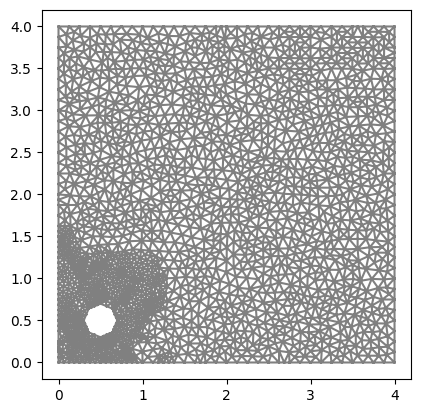

Total error = 0.025095081087336366


In [ ]:
x, y = 0.5, 0.5 #circle coordinates
r = 0.2 #circle radius
mesh = rect_mesh([[[x, y], r]])
solve_var(mesh)

Finally, the cylinder is centered at the coordinates $(3.5, 0.5)$:

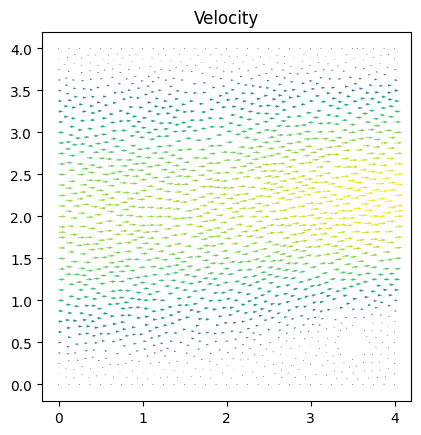

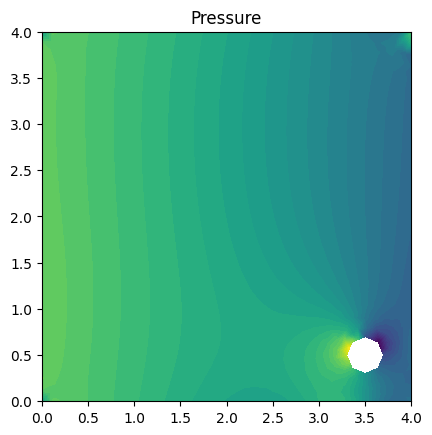

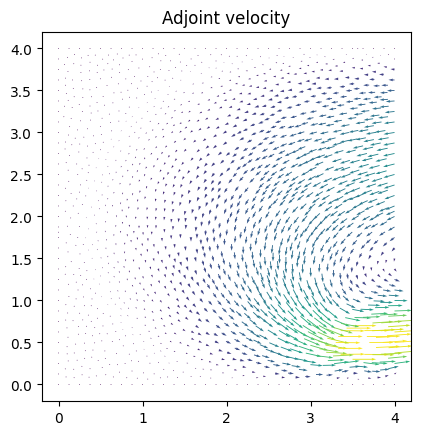

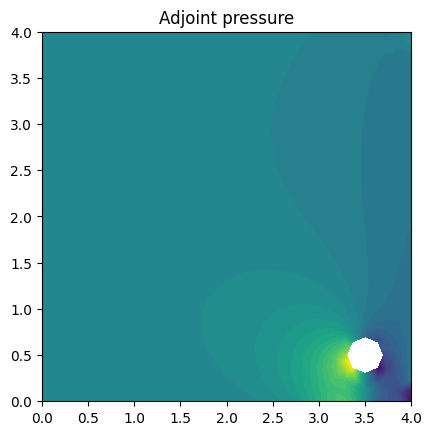

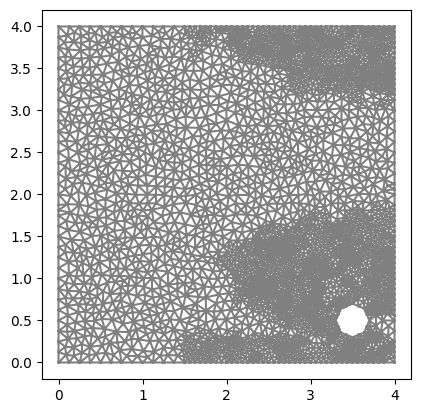

Total error = 0.001627887009658898


In [ ]:
x, y = 3.5, 0.5 #circle coordinates
r = 0.2 #circle radius
mesh = rect_mesh([[[x, y], r]])
solve_var(mesh)

For the examples above, we notice a pattern where the further to the right the cylinder is placed, the more the mesh will be refined around the nearby upper and lower walls of the mesh. Looking at the adjoint velocity, we also get clearer vortex patterns emerge close to the cylinder as it is moved closer to the center. As the cylinder is moved rightwards, we also see a general increase in the adjoing pressure across the entire mesh.

Next, we look at how changing the functional can affect the simulation. We start by considering the lift force, corresponding to the functional: $\hspace{3mm} \psi_1 = (0,0), \hspace{3mm} \psi_2 = 0, \hspace{3mm} \psi_3 = (0,1)$

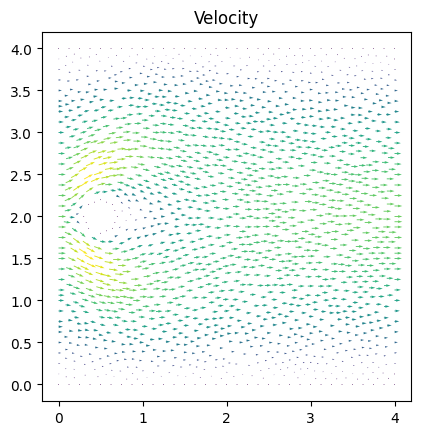

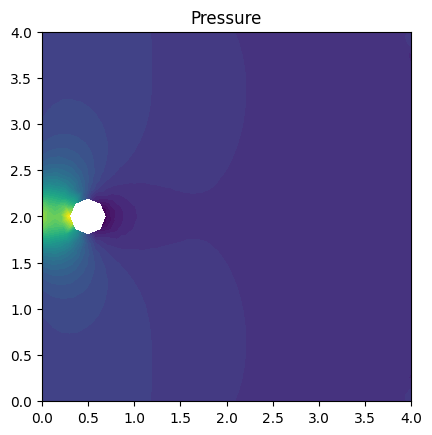

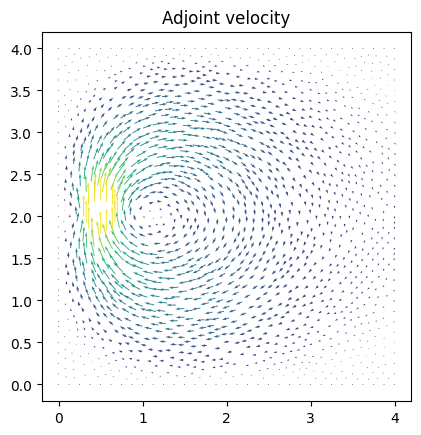

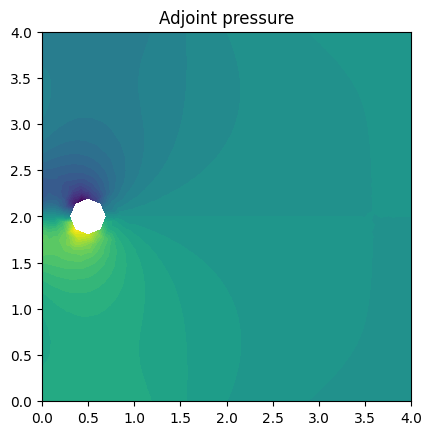

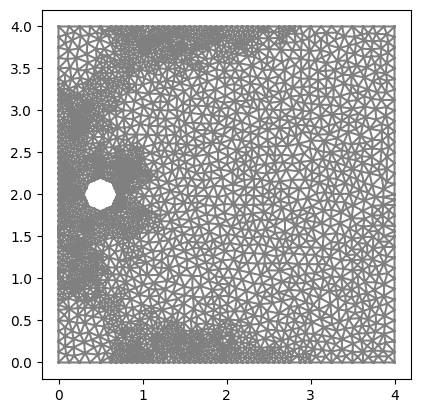

Total error = -0.0052300599648197445


In [13]:
x, y = 0.5, 2 #circle coordinates
r = 0.2 #circle radius
psi = (("0.0","0.0"), "0.0", ("0.0", "1.0"))
mesh = rect_mesh([[[x, y], r]])
solve_var(mesh, psi)

Here, we see a greater tendency for the mesh to be refined along the upper and lower bounds of the mesh. We also see a significant difference between the primal and adjoint pressure fields. 

Next, we considering the pressure: $\hspace{3mm} \psi_1 = (0,0), \hspace{3mm} \psi_2 = 1, \hspace{3mm} \psi_3 = (0,0)$

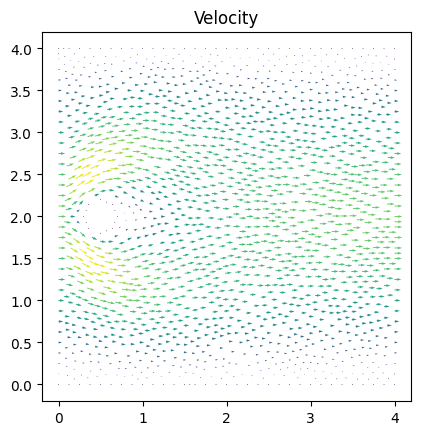

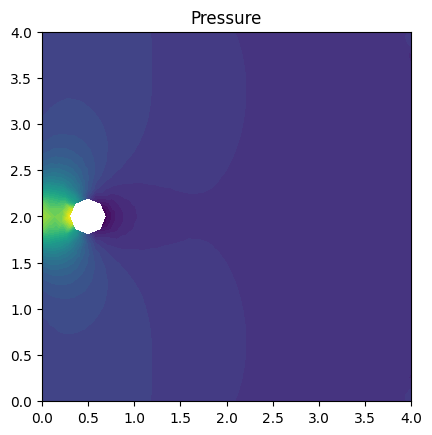

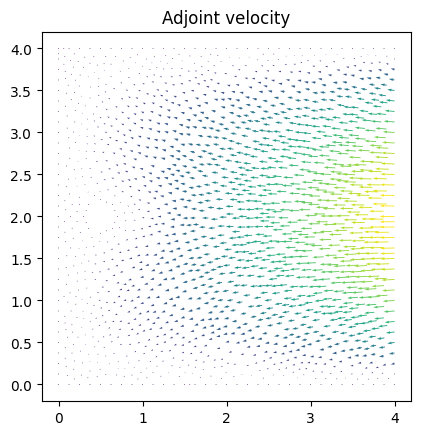

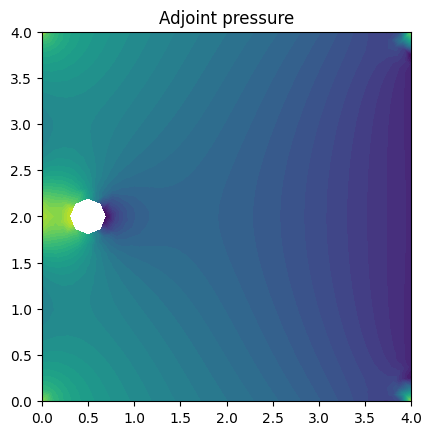

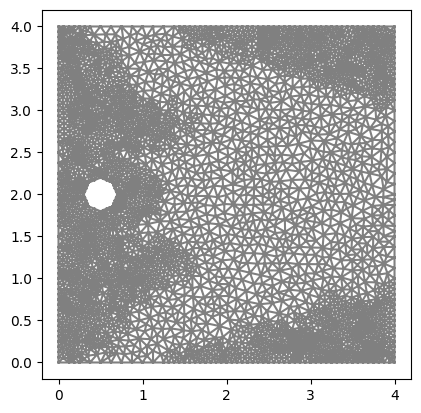

Total error = -0.0043495745790895915


In [9]:
x, y = 0.5, 2 #circle coordinates
r = 0.2 #circle radius
psi = (("0.0","0.0"), "1.0", ("0.0", "0.0"))
mesh = rect_mesh([[[x, y], r]])
solve_var(mesh, psi)

The pressure functional displays a complete shift in the adjoint velocity field when compared to the primal one, shifting its direction. We also see a greater extent of mesh refinement along the top and bottom right walls.

Finally, we consider the velocity in the x and y directions, using the functional

$\hspace{3mm} \psi_1 = (1,0), \hspace{3mm} \psi_2 = 0, \hspace{3mm} \psi_3 = (0,0)$

for velocity in the x-direction and

$\hspace{3mm} \psi_1 = (0,1), \hspace{3mm} \psi_2 = 0, \hspace{3mm} \psi_3 = (0,0)$

for the y-direction.

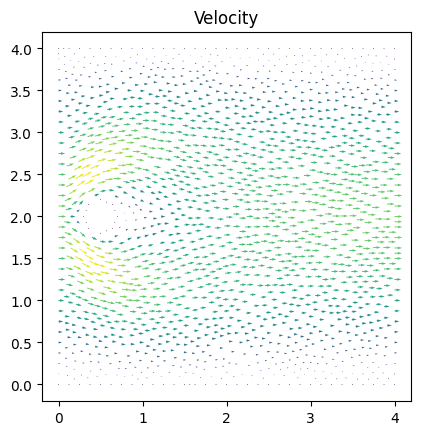

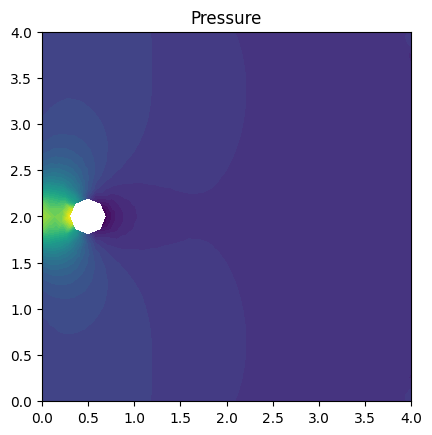

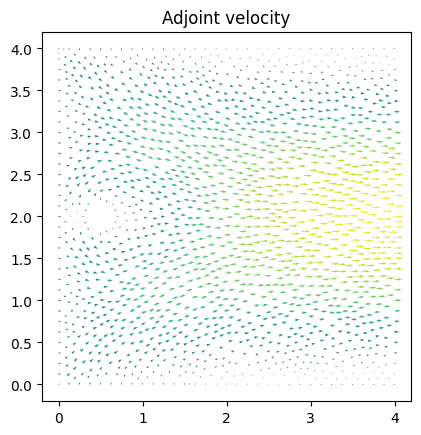

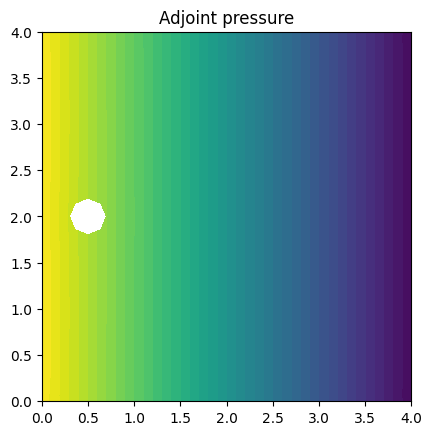

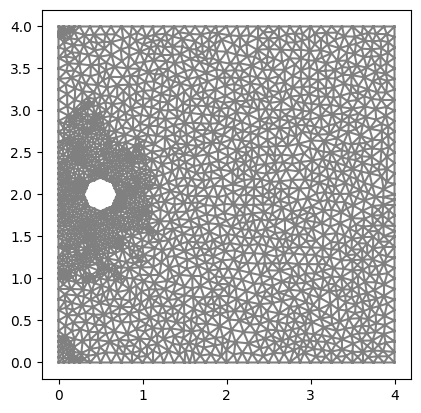

Total error = 3.327087656078558e-05


In [10]:
x, y = 0.5, 2 #circle coordinates
r = 0.2 #circle radius
psi = (("1.0","0.0"), "0.0", ("0.0", "0.0"))
mesh = rect_mesh([[[x, y], r]])
solve_var(mesh, psi)

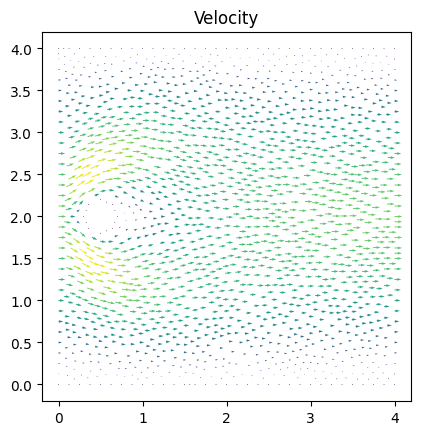

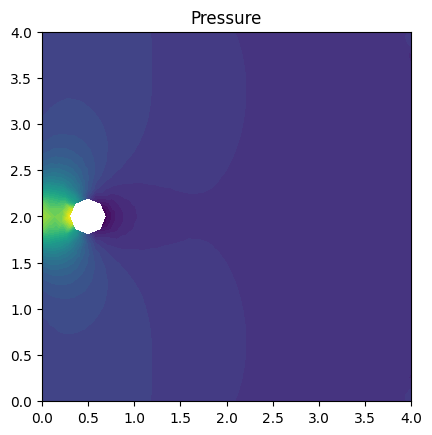

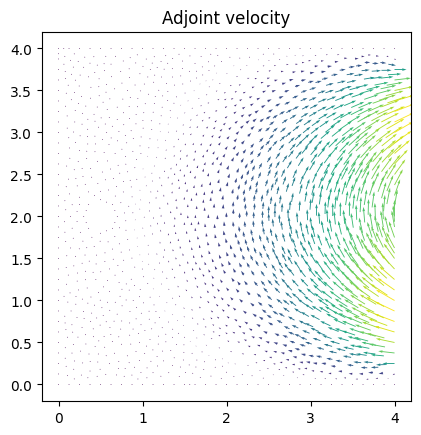

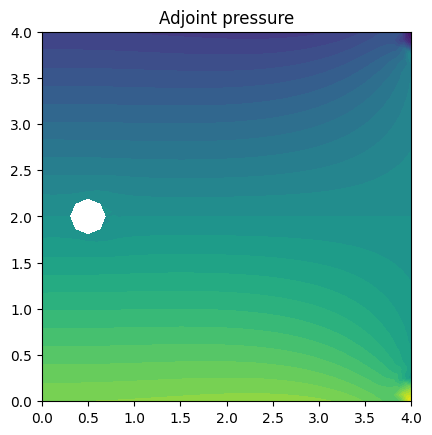

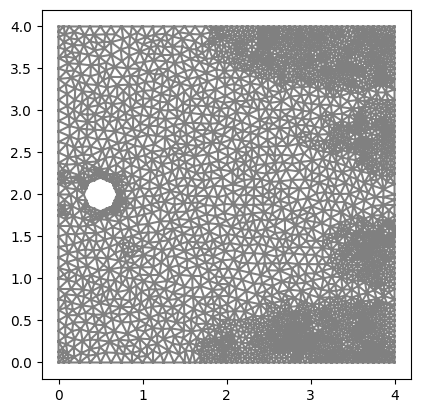

Total error = -0.00020759690409477062


In [11]:
x, y = 0.5, 2 #circle coordinates
r = 0.2 #circle radius
psi = (("0.0","1.0"), "0.0", ("0.0", "0.0"))
mesh = rect_mesh([[[x, y], r]])
solve_var(mesh, psi)

Interestingly enough, looking at the solution for the y-direction, we find that there is relatively little refinement around the actual cylinder, and more around the rightmost boundary. This is likely because the adjoint velocity is higher there, and thus the solution becomes more sensitive.

Finally, we have implemented a recursive local mesh refinement which will continuously re-refine the mesh until the total error of the adjoint solution is less than a threshold, here chosen as $10^{-5}$. Below is the output showing the result of the process.

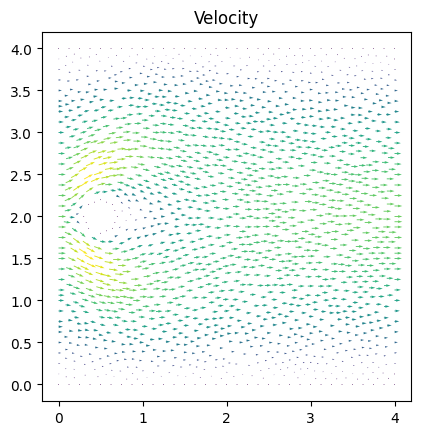

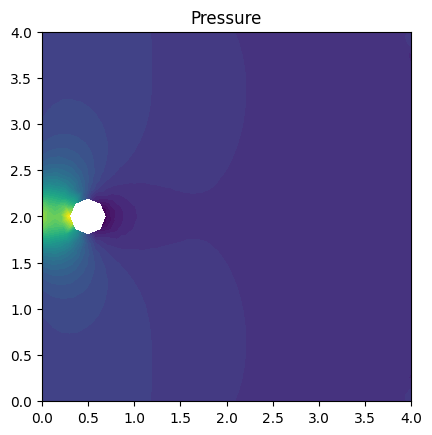

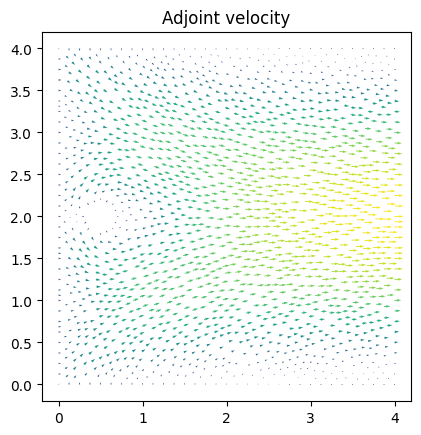

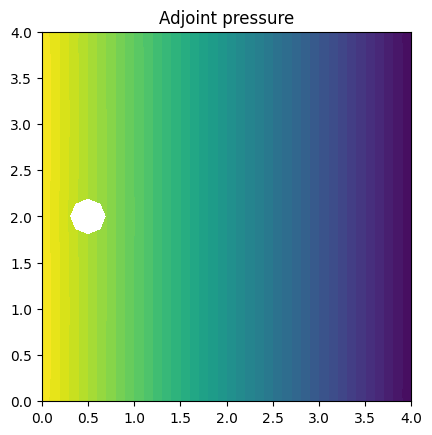

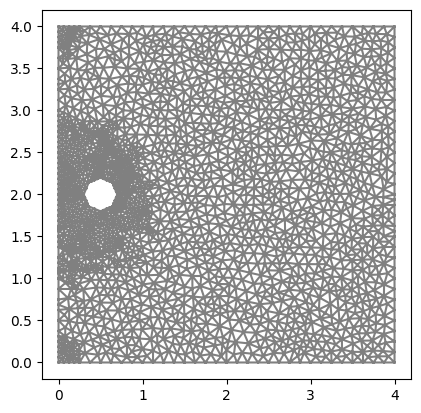

Total error = 3.974688094121942e-05


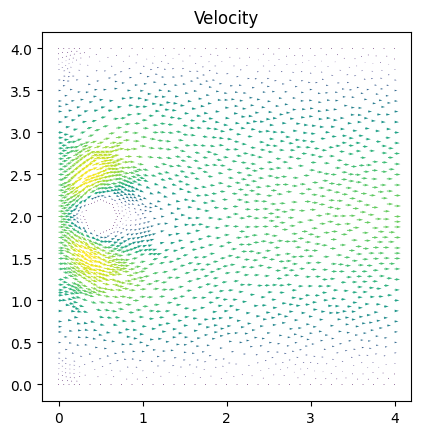

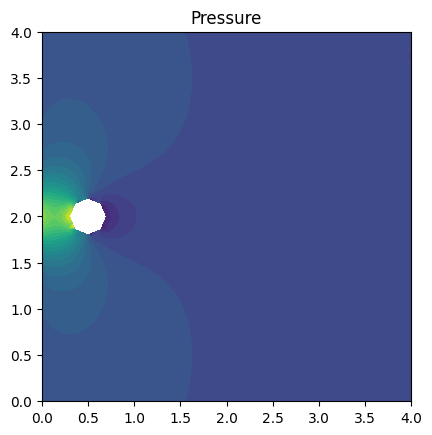

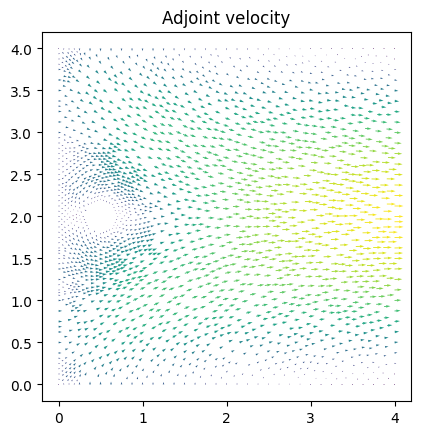

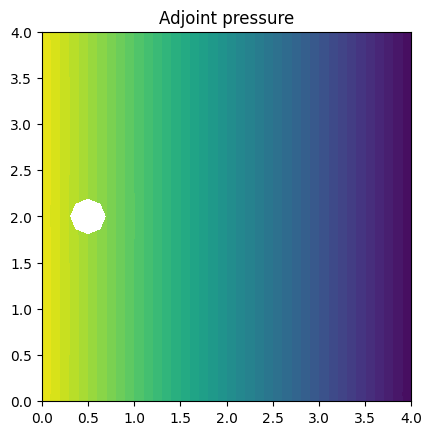

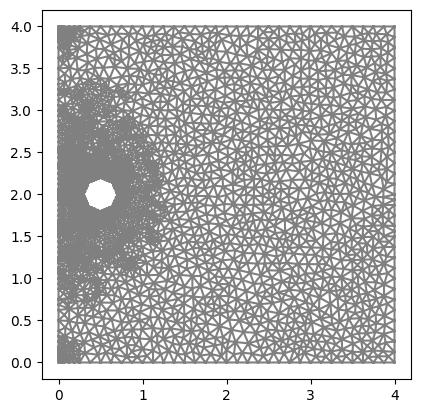

Total error = 1.0881440376334106e-05


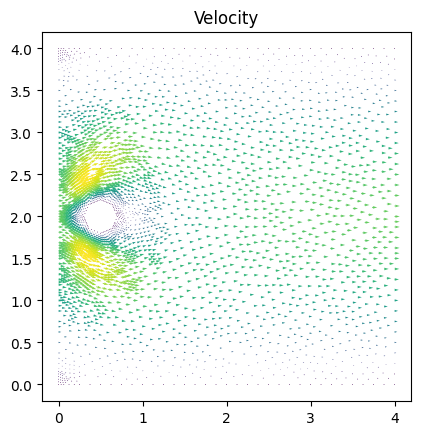

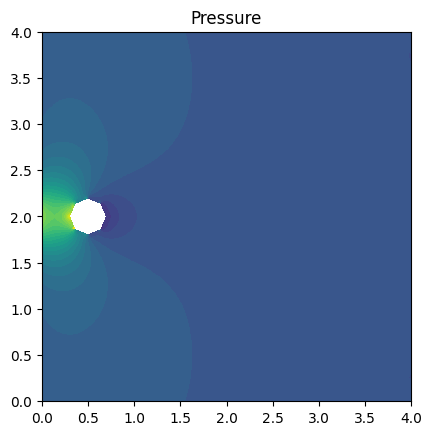

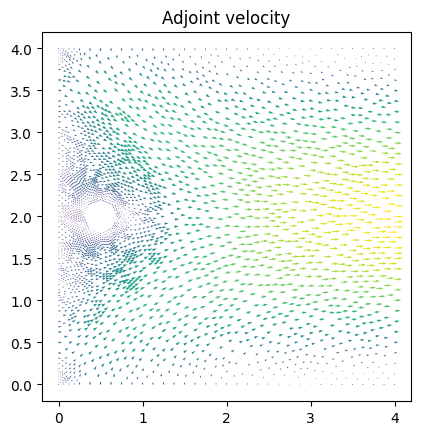

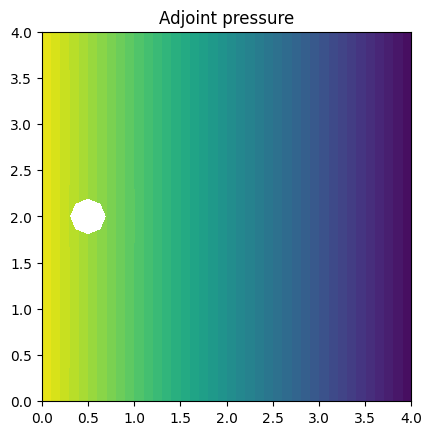

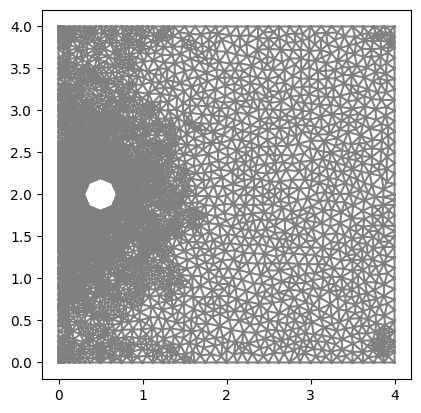

Total error = -1.1347637309681403e-05


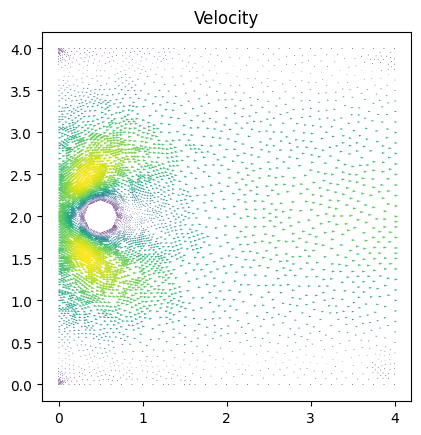

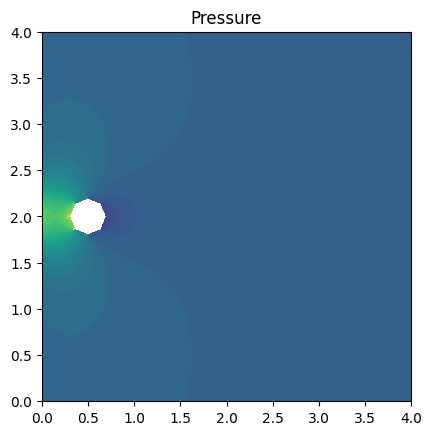

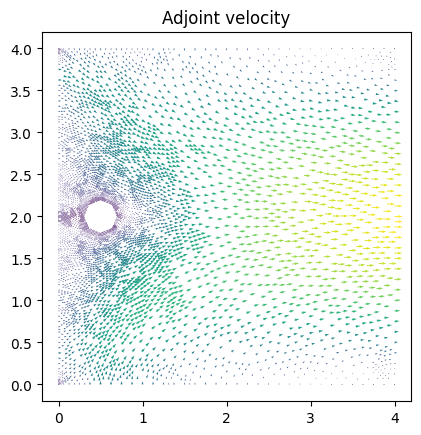

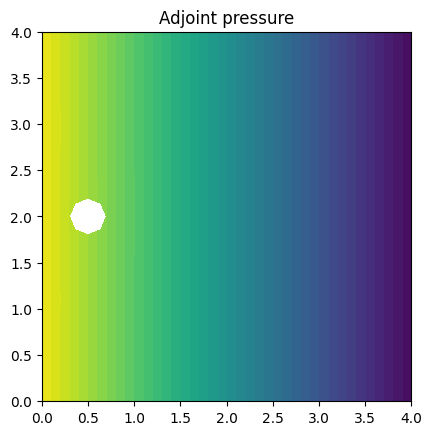

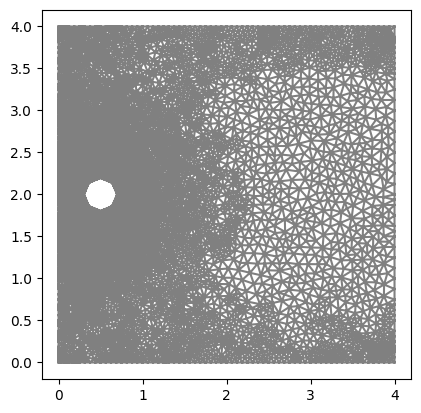

Total error = -7.971196141187014e-06


In [ ]:
x, y = 0.5, 2 #circle coordinates
r = 0.2 #circle radius
psi = (("1.0","0.0"), "0.0", ("0.0", "0.0"))
mesh = rect_mesh([[[x, y], r]])
solve_var(mesh, psi, recursive_refinement = True)

# **Discussion**

Through our results, we observed that the adjoint solution and the adaptive local mesh refinement depended greatly on the position of the cylinder in the mesh. Specifically, we observed that placing the cylinder further downstream, to the right, yielded higher total values of the adjoint pressure as well as a greater tendency to refine the mesh around the upper and lower walls. We also found that vortices tended to form more clearly when the cylinder was closer to the center.

We also implemented a recursive refinement of the mesh and found that the total error decreased with each iteration, allowing for the creation of a more accurate simulation.